# Implicit ODE converted to an index-1 DAE

This example is adapted from Lawder et al. (2015), Example 3: an implicit ODE that is made solvable by introducing an auxiliary variable and converting to a semi-explicit index‑1 DAE.

Reference: Lawder, M. T., Ramadesigan, V., Suthar, B., & Subramanian, V. R. (2015).  
**Extending explicit and linearly implicit ODE solvers for index‑1 DAEs.**  
Computers & Chemical Engineering, 82, 283–292.  
https://doi.org/10.1016/j.compchemeng.2015.06.012

---

## 1) Problem and idea

We start from the implicit ODE:
$$
\left(\frac{dy}{dt}\right)^2 + \left(\frac{dy}{dt}\right)\,(y+1) + y = \cos\!\left(\frac{dy}{dt}\right) \tag{1}
$$

This form cannot be passed directly to standard explicit ODE solvers, because the derivative appears nonlinearly. The key substitution is:
$$
\frac{dy}{dt} = z(t) \tag{2}
$$

Substituting into (1), we obtain an algebraic relation between $y$ and $z$:
$$
z^2 + z\,(y+1) + y = \cos(z) \tag{3}
$$

Together with $y' = z$, we have a **semi‑explicit index‑1 DAE**:
$$
\begin{aligned}
& y'(t) = z(t) \\
& 0 = z(t)^2 + z(t)\,(y(t)+1) + y(t) - \cos(z(t))
\end{aligned} \tag{4}
$$

We’ll use the consistent initial conditions requested:
- $y(0)=0$
- $z(0)=0.550$

> Pedagogical note: The algebraic equation defines $z$ implicitly as a function of $y$ at each time. The solver enforces this constraint while advancing $y$ by treating $z$ as an algebraic variable.

---

## 2) DAE formulation (mass‑matrix form)

We write the system $M\,\dot{x} = f(x)$ with $x=[y,\;z]^T$:
$$
M = \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix},\quad
f(x) = \begin{bmatrix} z \\ z^2 + z\,(y+1) + y - \cos(z) \end{bmatrix}.
$$

- The first row is differential ($y'$).
- The second row is algebraic (constraint in $y,z$).

This is a semi‑explicit index‑1 DAE: $z$ has no derivative and must satisfy the constraint at all times.

---

## 3) Short, interleaved code blocks with docstrings

Below, functions are defined with concise docstrings to keep the notebook readable and reusable.

In [1]:
import numpy as np

In [2]:
def fun_dae(t, x):
    """
    DAE right-hand side for the implicit ODE converted to a semi-explicit DAE.

    Parameters
    ----------
    t : float
        Current time.
    x : ndarray (2,)
        State vector [y, z].

    Returns
    -------
    f : ndarray (2,)
        Residuals for M x' = f(x):
        f[0] = z                         (so y' = z)
        f[1] = z^2 + z*(y+1) + y - cos(z)  (algebraic constraint)
    """
    y, z = x
    return np.array([z, z**2 + z*(y + 1.0) + y - np.cos(z)])

The Jacobian helps the implicit solver’s Newton iterations:

In [3]:
def jac_dae(t, x):
    """
    Jacobian of f with respect to [y, z].

    J = [ [ df0/dy, df0/dz ],
          [ df1/dy, df1/dz ] ]

    df0/dy = 0
    df0/dz = 1
    df1/dy = z + 1
    df1/dz = 2*z + (y + 1) + sin(z)   (since d/dz[-cos(z)] = +sin(z))

    Parameters
    ----------
    t : float
        Current time.
    x : ndarray (2,)
        State vector [y, z].

    Returns
    -------
    J : ndarray (2,2)
        Jacobian matrix.
    """
    y, z = x
    return np.array([
        [0.0, 1.0],
        [z + 1.0, 2.0*z + (y + 1.0) + np.sin(z)]
    ])


The mass matrix and variable indices define the DAE structure:

In [4]:
# Mass matrix: y is differential (row 1), z is algebraic (row 2)
mass = np.array([[1.0, 0.0],
                 [0.0, 0.0]])

# Variable index: 0 = differential, 1 = algebraic
var_index = np.array([0, 1])


Initial conditions (consistent with the algebraic constraint by construction):

In [5]:
y0 = 0.0
z0 = 0.550
x0 = np.array([y0, z0])


## 4) Solve the DAE and inspect results (timing + stats + residual checks)

We use a robust implicit DAE solver (RadauDAE). If you attempt a standard explicit ODE solver on (1), it will fail because the derivative appears nonlinearly and cannot be isolated.

In [6]:
import time
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from radauDAE import RadauDAE

In [7]:
# Time horizon and sampling
t_span = (0.0, 4.0)
t_eval = np.linspace(t_span[0], t_span[1], 400)

In [8]:
# --- Solve DAE with RadauDAE ---
t_start = time.time()
sol = solve_ivp(fun=fun_dae, t_span=t_span, y0=x0,
                method=RadauDAE,
                mass_matrix=mass,
                var_index=var_index,
                jac=jac_dae,
                rtol=1e-8, atol=1e-10,
                t_eval=t_eval,
                dense_output=True)
t_end = time.time()
runtime = t_end - t_start

print(f"[DAE] Finished in {runtime:.6f} s, steps={sol.t.size-1}, success={sol.success}")
print(f"[DAE] nfev={sol.nfev}, njev={sol.njev}, nlu={sol.nlu}")

[DAE] Finished in 0.071172 s, steps=399, success=True
[DAE] nfev=644, njev=8, nlu=20


In [9]:
# Extract y(t) and z(t)
y = sol.y[0]
z = sol.y[1]

# Check algebraic residual (should be ~0 within tolerance)
residual = z**2 + z*(y + 1.0) + y - np.cos(z)
res_inf = np.linalg.norm(residual, ord=np.inf)
print(f"Max-norm algebraic residual: {res_inf:.3e}")

Max-norm algebraic residual: 2.452e-05


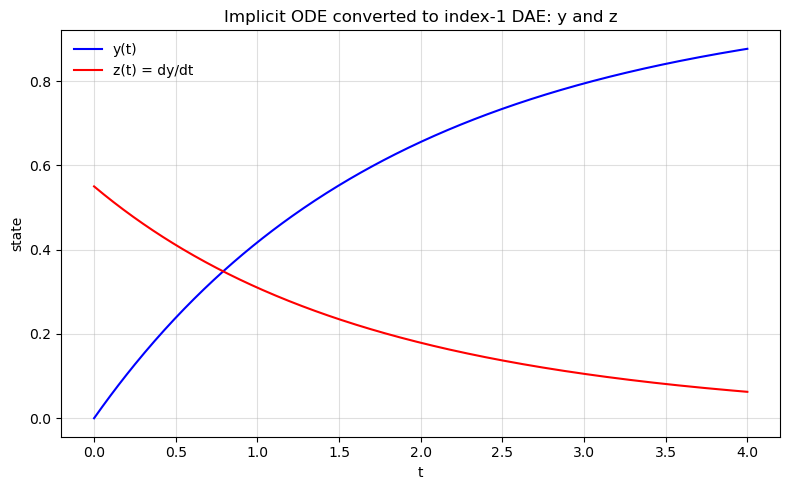

In [10]:
# Plot y and z over time
plt.figure(figsize=(8,5))
plt.plot(t_eval, y, 'b-', label='y(t)')
plt.plot(t_eval, z, 'r-', label='z(t) = dy/dt')
plt.xlabel('t')
plt.ylabel('state')
plt.title('Implicit ODE converted to index-1 DAE: y and z')
plt.legend(frameon=False)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()